In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv("../data/customers.csv")

### __1. Daten Vorbereiten__

In [37]:
from sklearn.preprocessing import StandardScaler


features = ["age", "monthly_spend", "data_volume_gb", "support_calls"]
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### __2. One-Class SVM trainieren - nur auf Nutzern__

In [38]:
from sklearn.svm import OneClassSVM

# Nur Nutzer auswählen
X_users = X_scaled[df["is_user"] == 1]

# One-Class SVM trainieren
svm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.05)
svm.fit(X_users)

OneClassSVM(gamma='auto', nu=0.05)

### __3. Vorhersage auf alle Kunden (Nutzer + Nicht Nutzer)__

In [39]:
# Vorhersage: +1 = ähnlich zu Nutzern, -1 = Outlier
df["is_never_user"] = svm.predict(X_scaled)
df["is_never_user"] = df["is_never_user"].map({1: 0, -1: 1})

### __4. Ergebnis prüfen__

In [40]:
# Wieviele Kunden sind "Nie-Nutzer"?
print(df["is_never_user"].value_counts())

# Anteil an den Nicht-Nutzern
nonusers = df[df["is_user"] == 0]
print("Nie-Nutzer_Anteil unter Nicht-Nutzern:",
      nonusers["is_never_user"].mean())

is_never_user
0    3490
1    1510
Name: count, dtype: int64
Nie-Nutzer_Anteil unter Nicht-Nutzern: 0.365


### __PCA-Plot__

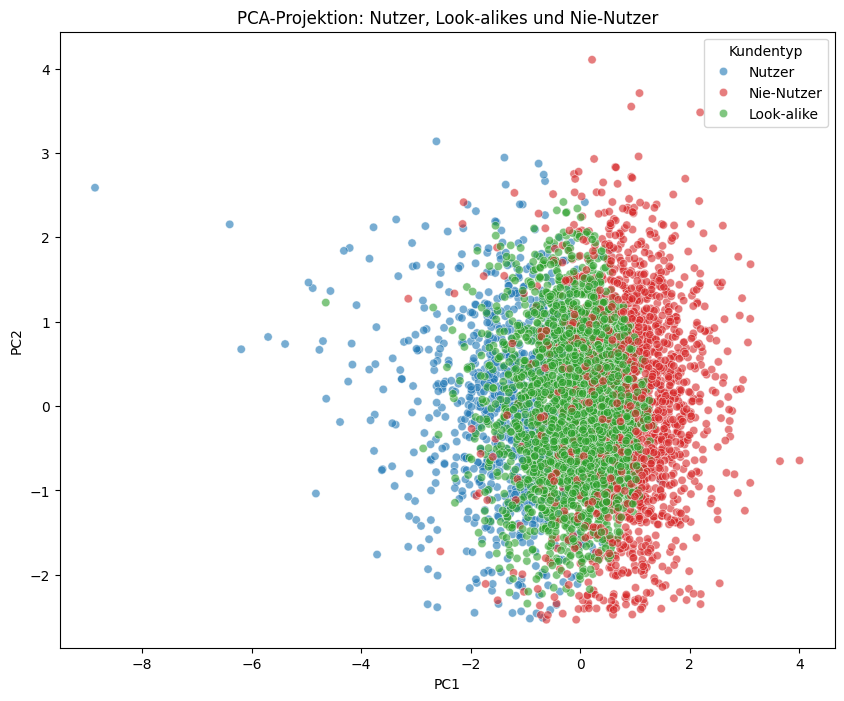

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
plot_df["is_user"] = df["is_user"]
plot_df["is_never_user"] = df["is_never_user"]

plot_df["label"] = plot_df.apply(
    lambda row: "Nutzer" if row["is_user"] == 1 else ("Nie-Nutzer" if row["is_never_user"] == 1 else "Look-alike"),
axis=1
)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="label", alpha=0.6, palette={
    "Nutzer": "#1f77b4",         # blau
    "Look-alike": "#2ca02c",     # grün
    "Nie-Nutzer": "#d62728"      # rot
})
plt.title("PCA-Projektion: Nutzer, Look-alikes und Nie-Nutzer")
plt.legend(title="Kundentyp")
plt.show()

In [42]:
df_model = df[df["is_never_user"] == 0].copy()

features = ["age", "monthly_spend", "data_volume_gb", "support_calls", "uses_selfservice"]
X = df_model[features]
y= df_model["is_user"]

X_scaled =  StandardScaler().fit_transform(X)

In [43]:
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=4.0)
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

ROC-AUC: 0.8577723425731811


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:57:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [44]:
df_model["propensity_score"] = model.predict_proba(X_scaled)[:, 1]

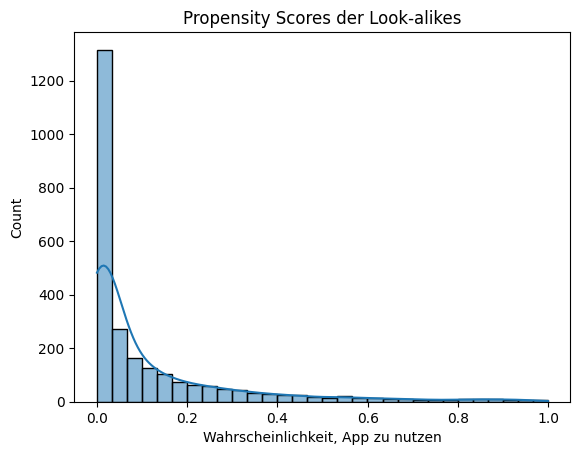

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_model[df_model["is_user"] == 0]["propensity_score"], bins=30, kde=True)
plt.title("Propensity Scores der Look-alikes")
plt.xlabel("Wahrscheinlichkeit, App zu nutzen")
plt.show()

In [46]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Input & Label (nur Nutzer + Look-alikes)
df_model = df[df["is_never_user"] == 0].copy()
X = df_model[["age", "monthly_spend", "data_volume_gb", "support_calls", "uses_selfservice", "contract_type", "device_os"]]
y = df_model["is_user"]

# Spalten aufteilen
numeric_features = ["age", "monthly_spend", "data_volume_gb", "support_calls"]
categorical_features = ["contract_type", "device_os"]
binary_features = ["uses_selfservice"]

# Preprocessing: Skalieren + OneHot für Kategorien
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("bin", "passthrough", binary_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

# Pipeline: Preprocessing + Modell
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(scale_pos_weight=4.0, use_label_encoder=False, eval_metric="logloss"))
])

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Trainieren
pipeline.fit(X_train, y_train)

# Bewertung
y_proba = pipeline.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Propensity Score für alle berechnen
df_model["propensity_score"] = pipeline.predict_proba(X)[:, 1]


ROC-AUC: 0.8294446746788231


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:57:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [47]:
# Nur Nicht-Nutzer (potenzielle Zielgruppe)
lookalikes = df_model[df_model["is_user"] == 0].copy()

# Segment einteilen
def segment(score):
    if score >= 0.7:
        return "hoch"
    elif score >= 0.3:
        return "mittel"
    else:
        return "niedrig"

lookalikes["segment"] = lookalikes["propensity_score"].apply(segment)


<Axes: title={'center': 'Verteilung der Look-alike Segmente'}, xlabel='segment'>

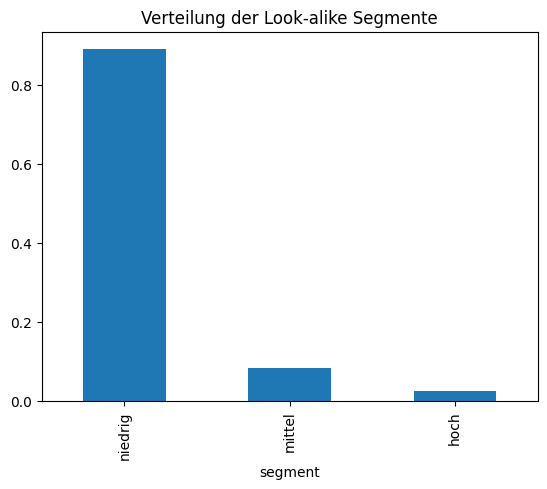

In [48]:
lookalikes["segment"].value_counts(normalize=True).plot(kind="bar", title="Verteilung der Look-alike Segmente")


In [49]:
# Top 10 Look-alikes mit höchster App-Nutzungswahrscheinlichkeit
top10 = lookalikes.sort_values("propensity_score", ascending=False).head(10)
top10[["customer_id", "propensity_score", "contract_type", "device_os"]]


,customer_id,propensity_score,contract_type,device_os
4113,CUST04113,0.999193,Family,Android
1804,CUST01804,0.998075,Postpaid,Unknown
3713,CUST03713,0.996439,Family,Android
1486,CUST01486,0.981426,Postpaid,Android
3814,CUST03814,0.977418,Young,iOS
3519,CUST03519,0.977390,Postpaid,iOS
1305,CUST01305,0.965864,Postpaid,iOS
4707,CUST04707,0.962374,Prepaid,iOS
3284,CUST03284,0.958771,Postpaid,iOS
1817,CUST01817,0.955505,Family,Android


In [50]:
# Transformierte Inputs extrahieren
X_preprocessed = pipeline.named_steps["prep"].transform(X)

# XGBoost-Modell extrahieren (aus Pipeline)
model = pipeline.named_steps["clf"]


In [51]:
import shap

# SHAP-Explainer erzeugen
explainer = shap.Explainer(model)
shap_values = explainer(X_preprocessed)


In [52]:
# Feature-Namen aus Pipeline rekonstruieren
ohe = pipeline.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(["contract_type", "device_os"])
feature_names = numeric_features + binary_features + list(cat_names)

# SHAP-Werte als DataFrame mit korrekten Spaltennamen
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)



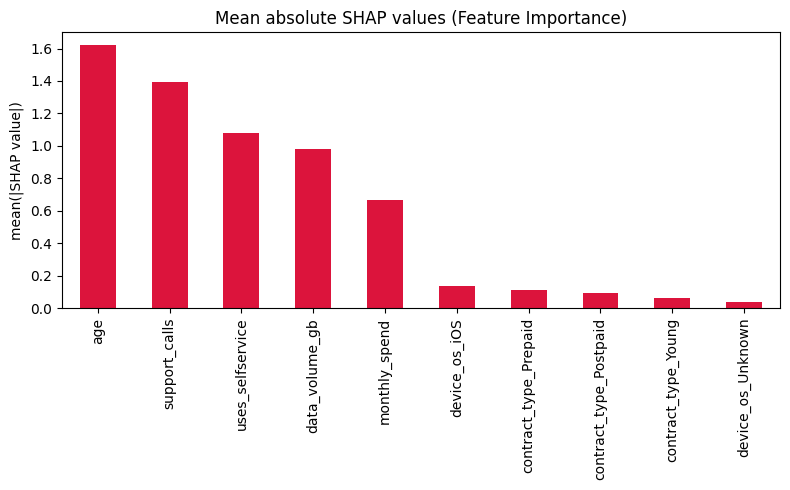

In [53]:
import numpy as np
import matplotlib.pyplot as plt

mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
mean_abs_shap.plot(kind="bar", color="crimson")
plt.title("Mean absolute SHAP values (Feature Importance)")
plt.ylabel("mean(|SHAP value|)")
plt.tight_layout()
plt.show()
